In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, WeightedRandomSampler
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

In [2]:
import os
import torch
from torchvision import models

# 저장 경로
photo_model_path = "/workspace/models/Inception/inception_pretrained_photo.pth"

# 디렉터리 생성 (이미 존재해도 OK)
os.makedirs(os.path.dirname(photo_model_path), exist_ok=True)

# 모델 불러오기 및 저장
model = models.inception_v3(pretrained=True)
torch.save(model.state_dict(), photo_model_path)

print(f"✅ 모델이 저장되었습니다: {photo_model_path}")

/workspace/.conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/workspace/.conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ 모델이 저장되었습니다: /workspace/models/Inception/inception_pretrained_photo.pth


In [3]:
# 디바이스 설정
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ 사용 디바이스: {DEVICE}")

if torch.cuda.is_available():
    print("🖥️ GPU 이름:", torch.cuda.get_device_name(0))

✅ 사용 디바이스: cuda
🖥️ GPU 이름: NVIDIA RTX 4000 Ada Generation


In [4]:
BATCH_SIZE = 32
NUM_CLASSES = 4
EPOCHS_PRETRAIN = 30
EPOCHS_FINETUNE = 30
PATIENCE = 5
IMG_SIZE = 299
LR_PRETRAIN = 5e-5
LR_FINETUNE = 1e-5
DROPOUT = 0.3

# === 경로 설정 ===
photo_train = "/workspace/datasets/dataset2yolo/photo/train"
photo_val = "/workspace/datasets/dataset2yolo/photo/val"
drawing_train = "/workspace/datasets/dataset2yolo/drawing/train"
drawing_val = "/workspace/datasets/dataset2yolo/drawing/val"
photo_model_path = "/workspace/models/Inception/inception_pretrained_photo.pth"
drawing_model_path = "/workspace/models/Inception/inception_finetuned_drawing.pth"

# === ImageNet 정규화 ===
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

In [5]:
# === Inception v3용 데이터 증강 ===

train_transform = transforms.Compose([
    transforms.Resize((342, 342)),
    transforms.RandomResizedCrop(299),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.ToTensor(),  # ← RandomErasing 이전에 위치
    transforms.Normalize(mean, std),
    transforms.RandomErasing(p=0.3),  # ← ToTensor() 이후에 위치
])

val_transform = transforms.Compose([
    transforms.Resize((342, 342)),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

In [6]:
# # === DataLoader 생성 함수 ===
# def get_dataloaders(train_dir, val_dir, batch_size=32):
#     train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
#     val_dataset = datasets.ImageFolder(val_dir, transform=val_transform)

#     train_loader = torch.utils.data.DataLoader(
#         train_dataset, 
#         batch_size=batch_size, 
#         shuffle=True,
#         num_workers=4,  # 데이터 로딩 속도 향상
#         pin_memory=True  # GPU 사용 시 성능 향상
#     )
#     val_loader = torch.utils.data.DataLoader(
#         val_dataset, 
#         batch_size=batch_size, 
#         shuffle=False,
#         num_workers=4,
#         pin_memory=True
#     )

#     class_names = train_dataset.classes
#     return train_loader, val_loader, class_names, len(class_names)


In [7]:
def get_dataloaders(train_dir, val_dir, batch_size=32, use_weight=False):
    train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
    val_dataset = datasets.ImageFolder(val_dir, transform=val_transform)

    class_weights = None
    train_sampler = None

    if use_weight:
        # 📊 클래스 불균형 처리를 위한 샘플 가중치 계산
        targets = train_dataset.targets
        class_counts = Counter(targets)
        total_samples = len(train_dataset)

        # 클래스별 weight: 클래스 수 / 샘플 수 비율
        weights = [total_samples / (len(class_counts) * class_counts[i]) for i in range(len(class_counts))]
        sample_weights = [weights[label] for label in targets]

        # WeightedRandomSampler 생성
        train_sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
        class_weights = torch.FloatTensor(weights).to(DEVICE)

        print(f"📊 클래스 분포: {dict(class_counts)}")
        print(f"⚖️ 클래스 가중치: {weights}")

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=(train_sampler is None),
        sampler=train_sampler,
        num_workers=8,  # ✅ 병렬 로딩
        pin_memory=True
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=8,  # ✅ 병렬 로딩
        pin_memory=True
    )

    class_names = train_dataset.classes
    return train_loader, val_loader, class_names, class_weights

# === 수정된 Inception v3 학습 함수 ===
def train_model(model, train_loader, val_loader, save_path, epochs, lr, class_weights=None):
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    best_val_acc = 0
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        train_loss, train_correct = 0, 0
        print(f"\n📘 Epoch {epoch+1}/{epochs}")

        for imgs, labels in tqdm(train_loader, desc="🟦 Training", leave=False):
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            
            # Inception v3의 경우 training 모드에서 aux_logits 반환
            if model.training and hasattr(model, 'aux_logits') and model.aux_logits:
                outputs, aux_outputs = model(imgs)
                loss1 = criterion(outputs, labels)
                loss2 = criterion(aux_outputs, labels)
                loss = loss1 + 0.4 * loss2
            else:
                outputs = model(imgs)
                loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_correct += (outputs.argmax(1) == labels).sum().item()

        train_acc = train_correct / len(train_loader.dataset)

        # 검증
        model.eval()
        val_loss, val_correct = 0, 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for imgs, labels in tqdm(val_loader, desc="🟨 Validating", leave=False):
                imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
                outputs = model(imgs)
                
                # 검증 시에는 main output만 사용
                if isinstance(outputs, tuple):
                    outputs = outputs[0]
                
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_correct += (outputs.argmax(1) == labels).sum().item()
                all_preds.extend(outputs.argmax(1).cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_acc = val_correct / len(val_loader.dataset)
        scheduler.step()

        print(f"📊 Epoch {epoch+1}: "
              f"Train Loss = {train_loss/len(train_loader):.4f}, "
              f"Train Acc = {train_acc:.4f} | "
              f"Val Loss = {val_loss/len(val_loader):.4f}, "
              f"Val Acc = {val_acc:.4f}")

        # 최고 성능 모델 저장
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), save_path)
            patience_counter = 0
            print(f"✅ 새로운 최고 성능! 모델 저장됨 (Val Acc: {val_acc:.4f})")
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"🛑 Early stopping! (Patience: {PATIENCE})")
                break

    return all_preds, all_labels

In [8]:
# === Step 1: 사진 데이터 학습 (사전학습) ===
print("📸 사진 데이터 로딩 중...")
photo_train_loader, photo_val_loader, class_names, _ = get_dataloaders(photo_train, photo_val)

print(f"📊 클래스: {class_names}")
print(f"📊 훈련 데이터: {len(photo_train_loader.dataset)}개")
print(f"📊 검증 데이터: {len(photo_val_loader.dataset)}개")

# Inception v3 모델 생성
print("🤖 Inception v3 모델 생성 중...")
model = models.inception_v3(pretrained=True, aux_logits=True)
model.fc = nn.Sequential(
    nn.Dropout(DROPOUT),
    nn.Linear(model.fc.in_features, NUM_CLASSES)
)
model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, NUM_CLASSES)
model.to(DEVICE)

print(f"🎯 모델 파라미터 수: {sum(p.numel() for p in model.parameters()):,}")

# 학습 수행
print("🚀 사전학습 시작!")
train_model(
    model,
    photo_train_loader,
    photo_val_loader,
    save_path=photo_model_path,
    epochs=EPOCHS_PRETRAIN,
    lr=LR_PRETRAIN,
    class_weights=None
)

print(f"✅ 사전학습 완료! 모델이 저장됨: {photo_model_path}")

📸 사진 데이터 로딩 중...
📊 클래스: ['angry', 'fear', 'happy', 'sad']
📊 훈련 데이터: 5756개
📊 검증 데이터: 1440개
🤖 Inception v3 모델 생성 중...


🎯 모델 파라미터 수: 24,354,536
🚀 사전학습 시작!

📘 Epoch 1/30


📊 Epoch 1: Train Loss = 1.7300, Train Acc = 0.4114 | Val Loss = 0.8266, Val Acc = 0.6722
✅ 새로운 최고 성능! 모델 저장됨 (Val Acc: 0.6722)

📘 Epoch 2/30


📊 Epoch 2: Train Loss = 1.3026, Train Acc = 0.5992 | Val Loss = 0.6669, Val Acc = 0.7535
✅ 새로운 최고 성능! 모델 저장됨 (Val Acc: 0.7535)

📘 Epoch 3/30


📊 Epoch 3: Train Loss = 1.1235, Train Acc = 0.6579 | Val Loss = 0.5438, Val Acc = 0.7896
✅ 새로운 최고 성능! 모델 저장됨 (Val Acc: 0.7896)

📘 Epoch 4/30


📊 Epoch 4: Train Loss = 1.0477, Train Acc = 0.6807 | Val Loss = 0.5626, Val Acc = 0.7847

📘 Epoch 5/30


📊 Epoch 5: Train Loss = 0.9573, Train Acc = 0.7226 | Val Loss = 0.4975, Val Acc = 0.8160
✅ 새로운 최고 성능! 모델 저장됨 (Val Acc: 0.8160)

📘 Epoch 6/30


📊 Epoch 6: Train Loss = 0.9399, Train Acc = 0.7189 | Val Loss = 0.4814, Val Acc = 0.8222
✅ 새로운 최고 성능! 모델 저장됨 (Val Acc: 0.8222)

📘 Epoch 7/30


📊 Epoch 7: Train Loss = 0.8978, Train Acc = 0.7403 | Val Loss = 0.4799, Val Acc = 0.8236
✅ 새로운 최고 성능! 모델 저장됨 (Val Acc: 0.8236)

📘 Epoch 8/30


📊 Epoch 8: Train Loss = 0.8853, Train Acc = 0.7404 | Val Loss = 0.4517, Val Acc = 0.8375
✅ 새로운 최고 성능! 모델 저장됨 (Val Acc: 0.8375)

📘 Epoch 9/30


📊 Epoch 9: Train Loss = 0.8551, Train Acc = 0.7526 | Val Loss = 0.5102, Val Acc = 0.8181

📘 Epoch 10/30


📊 Epoch 10: Train Loss = 0.8384, Train Acc = 0.7446 | Val Loss = 0.5718, Val Acc = 0.8021

📘 Epoch 11/30


📊 Epoch 11: Train Loss = 0.7709, Train Acc = 0.7757 | Val Loss = 0.5568, Val Acc = 0.8007

📘 Epoch 12/30


📊 Epoch 12: Train Loss = 0.7605, Train Acc = 0.7794 | Val Loss = 0.4723, Val Acc = 0.8465
✅ 새로운 최고 성능! 모델 저장됨 (Val Acc: 0.8465)

📘 Epoch 13/30


📊 Epoch 13: Train Loss = 0.7475, Train Acc = 0.7733 | Val Loss = 0.4214, Val Acc = 0.8535
✅ 새로운 최고 성능! 모델 저장됨 (Val Acc: 0.8535)

📘 Epoch 14/30


📊 Epoch 14: Train Loss = 0.7100, Train Acc = 0.7867 | Val Loss = 0.4119, Val Acc = 0.8542
✅ 새로운 최고 성능! 모델 저장됨 (Val Acc: 0.8542)

📘 Epoch 15/30


📊 Epoch 15: Train Loss = 0.6948, Train Acc = 0.7934 | Val Loss = 0.3987, Val Acc = 0.8597
✅ 새로운 최고 성능! 모델 저장됨 (Val Acc: 0.8597)

📘 Epoch 16/30


📊 Epoch 16: Train Loss = 0.6740, Train Acc = 0.8039 | Val Loss = 0.4447, Val Acc = 0.8507

📘 Epoch 17/30


📊 Epoch 17: Train Loss = 0.6696, Train Acc = 0.8039 | Val Loss = 0.4399, Val Acc = 0.8438

📘 Epoch 18/30


📊 Epoch 18: Train Loss = 0.6317, Train Acc = 0.8153 | Val Loss = 0.4570, Val Acc = 0.8458

📘 Epoch 19/30


📊 Epoch 19: Train Loss = 0.6025, Train Acc = 0.8176 | Val Loss = 0.4440, Val Acc = 0.8507

📘 Epoch 20/30


📊 Epoch 20: Train Loss = 0.6144, Train Acc = 0.8181 | Val Loss = 0.4357, Val Acc = 0.8521
🛑 Early stopping! (Patience: 5)
✅ 사전학습 완료! 모델이 저장됨: /workspace/models/Inception/inception_pretrained_photo.pth


In [9]:
# === Step 2: 그림 데이터 파인튜닝 ===
print("\n" + "="*60)
print("🎨 Step 2: 그림 데이터 파인튜닝 시작!")
print("="*60)

print("🎨 그림 데이터 로딩 중...")
drawing_train_loader, drawing_val_loader, drawing_class_names, drawing_weights = get_dataloaders(
    drawing_train, drawing_val, use_weight=True)

print(f"📊 그림 데이터 클래스: {drawing_class_names}")
print(f"📊 그림 훈련 데이터: {len(drawing_train_loader.dataset)}개")
print(f"📊 그림 검증 데이터: {len(drawing_val_loader.dataset)}개")

# 학습한 사전학습 모델 불러오기
print("📥 사전학습된 모델 불러오는 중...")
model = models.inception_v3(pretrained=False, aux_logits=True)
model.fc = nn.Sequential(
    nn.Dropout(DROPOUT),
    nn.Linear(model.fc.in_features, NUM_CLASSES)
)
model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, NUM_CLASSES)

# 사전학습된 가중치 로드
try:
    model.load_state_dict(torch.load(photo_model_path, map_location=DEVICE))
    print("✅ 사전학습된 모델 가중치 로드 완료!")
except FileNotFoundError:
    print("❌ 사전학습된 모델 파일을 찾을 수 없습니다!")
    print("Step 1을 먼저 실행해주세요.")
    raise

model.to(DEVICE)

# 파인튜닝을 위한 학습률 조정 (더 낮은 학습률 사용)
print(f"🎯 파인튜닝 학습률: {LR_FINETUNE}")
print(f"⚖️ 클래스 가중치 사용: {'Yes' if drawing_weights is not None else 'No'}")

# 파인튜닝 수행
print("🚀 파인튜닝 시작!")
preds, labels = train_model(
    model,
    train_loader=drawing_train_loader,
    val_loader=drawing_val_loader,
    save_path=drawing_model_path,
    epochs=EPOCHS_FINETUNE,
    lr=LR_FINETUNE,
    class_weights=drawing_weights
)

print(f"✅ 파인튜닝 완료! 모델이 저장됨: {drawing_model_path}")

/workspace/.conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/workspace/.conda/lib/python3.11/site-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(



🎨 Step 2: 그림 데이터 파인튜닝 시작!
🎨 그림 데이터 로딩 중...
📊 클래스 분포: {0: 318, 1: 294, 2: 567, 3: 360}
⚖️ 클래스 가중치: [1.2099056603773586, 1.308673469387755, 0.6785714285714286, 1.06875]
📊 그림 데이터 클래스: ['angry', 'fear', 'happy', 'sad']
📊 그림 훈련 데이터: 1539개
📊 그림 검증 데이터: 472개
📥 사전학습된 모델 불러오는 중...


✅ 사전학습된 모델 가중치 로드 완료!
🎯 파인튜닝 학습률: 1e-05
⚖️ 클래스 가중치 사용: Yes
🚀 파인튜닝 시작!

📘 Epoch 1/30


📊 Epoch 1: Train Loss = 2.4811, Train Acc = 0.3184 | Val Loss = 1.4948, Val Acc = 0.4004
✅ 새로운 최고 성능! 모델 저장됨 (Val Acc: 0.4004)

📘 Epoch 2/30


📊 Epoch 2: Train Loss = 1.8180, Train Acc = 0.4204 | Val Loss = 1.2680, Val Acc = 0.4428
✅ 새로운 최고 성능! 모델 저장됨 (Val Acc: 0.4428)

📘 Epoch 3/30


📊 Epoch 3: Train Loss = 1.7205, Train Acc = 0.4288 | Val Loss = 1.0749, Val Acc = 0.5508
✅ 새로운 최고 성능! 모델 저장됨 (Val Acc: 0.5508)

📘 Epoch 4/30


📊 Epoch 4: Train Loss = 1.5852, Train Acc = 0.5250 | Val Loss = 0.9621, Val Acc = 0.6017
✅ 새로운 최고 성능! 모델 저장됨 (Val Acc: 0.6017)

📘 Epoch 5/30


📊 Epoch 5: Train Loss = 1.4745, Train Acc = 0.5634 | Val Loss = 0.9006, Val Acc = 0.6271
✅ 새로운 최고 성능! 모델 저장됨 (Val Acc: 0.6271)

📘 Epoch 6/30


📊 Epoch 6: Train Loss = 1.4256, Train Acc = 0.5932 | Val Loss = 0.8171, Val Acc = 0.6949
✅ 새로운 최고 성능! 모델 저장됨 (Val Acc: 0.6949)

📘 Epoch 7/30


📊 Epoch 7: Train Loss = 1.3773, Train Acc = 0.6062 | Val Loss = 0.7883, Val Acc = 0.6970
✅ 새로운 최고 성능! 모델 저장됨 (Val Acc: 0.6970)

📘 Epoch 8/30


📊 Epoch 8: Train Loss = 1.2835, Train Acc = 0.6283 | Val Loss = 0.7569, Val Acc = 0.6970

📘 Epoch 9/30


📊 Epoch 9: Train Loss = 1.2673, Train Acc = 0.6485 | Val Loss = 0.7247, Val Acc = 0.7076
✅ 새로운 최고 성능! 모델 저장됨 (Val Acc: 0.7076)

📘 Epoch 10/30


📊 Epoch 10: Train Loss = 1.2076, Train Acc = 0.6452 | Val Loss = 0.6662, Val Acc = 0.7500
✅ 새로운 최고 성능! 모델 저장됨 (Val Acc: 0.7500)

📘 Epoch 11/30


📊 Epoch 11: Train Loss = 1.1773, Train Acc = 0.6732 | Val Loss = 0.6743, Val Acc = 0.7309

📘 Epoch 12/30


📊 Epoch 12: Train Loss = 1.1539, Train Acc = 0.6797 | Val Loss = 0.6496, Val Acc = 0.7648
✅ 새로운 최고 성능! 모델 저장됨 (Val Acc: 0.7648)

📘 Epoch 13/30


📊 Epoch 13: Train Loss = 1.1143, Train Acc = 0.6946 | Val Loss = 0.6002, Val Acc = 0.7712
✅ 새로운 최고 성능! 모델 저장됨 (Val Acc: 0.7712)

📘 Epoch 14/30


📊 Epoch 14: Train Loss = 1.1091, Train Acc = 0.6920 | Val Loss = 0.5909, Val Acc = 0.7903
✅ 새로운 최고 성능! 모델 저장됨 (Val Acc: 0.7903)

📘 Epoch 15/30


📊 Epoch 15: Train Loss = 1.0284, Train Acc = 0.7297 | Val Loss = 0.5685, Val Acc = 0.8051
✅ 새로운 최고 성능! 모델 저장됨 (Val Acc: 0.8051)

📘 Epoch 16/30


📊 Epoch 16: Train Loss = 1.0474, Train Acc = 0.7128 | Val Loss = 0.5811, Val Acc = 0.7945

📘 Epoch 17/30


📊 Epoch 17: Train Loss = 1.0018, Train Acc = 0.7310 | Val Loss = 0.5536, Val Acc = 0.8093
✅ 새로운 최고 성능! 모델 저장됨 (Val Acc: 0.8093)

📘 Epoch 18/30


📊 Epoch 18: Train Loss = 0.9989, Train Acc = 0.7420 | Val Loss = 0.5569, Val Acc = 0.8157
✅ 새로운 최고 성능! 모델 저장됨 (Val Acc: 0.8157)

📘 Epoch 19/30


📊 Epoch 19: Train Loss = 0.9596, Train Acc = 0.7414 | Val Loss = 0.5283, Val Acc = 0.8178
✅ 새로운 최고 성능! 모델 저장됨 (Val Acc: 0.8178)

📘 Epoch 20/30


📊 Epoch 20: Train Loss = 1.0067, Train Acc = 0.7368 | Val Loss = 0.5546, Val Acc = 0.8051

📘 Epoch 21/30


📊 Epoch 21: Train Loss = 0.9435, Train Acc = 0.7557 | Val Loss = 0.5511, Val Acc = 0.8136

📘 Epoch 22/30


📊 Epoch 22: Train Loss = 0.9398, Train Acc = 0.7524 | Val Loss = 0.5314, Val Acc = 0.8199
✅ 새로운 최고 성능! 모델 저장됨 (Val Acc: 0.8199)

📘 Epoch 23/30


📊 Epoch 23: Train Loss = 0.9667, Train Acc = 0.7492 | Val Loss = 0.5853, Val Acc = 0.7987

📘 Epoch 24/30


📊 Epoch 24: Train Loss = 0.9297, Train Acc = 0.7713 | Val Loss = 0.5385, Val Acc = 0.8220
✅ 새로운 최고 성능! 모델 저장됨 (Val Acc: 0.8220)

📘 Epoch 25/30


📊 Epoch 25: Train Loss = 0.9682, Train Acc = 0.7323 | Val Loss = 0.5357, Val Acc = 0.8093

📘 Epoch 26/30


📊 Epoch 26: Train Loss = 0.9220, Train Acc = 0.7667 | Val Loss = 0.5330, Val Acc = 0.8114

📘 Epoch 27/30


📊 Epoch 27: Train Loss = 0.9349, Train Acc = 0.7648 | Val Loss = 0.5346, Val Acc = 0.8051

📘 Epoch 28/30


📊 Epoch 28: Train Loss = 0.9011, Train Acc = 0.7674 | Val Loss = 0.5283, Val Acc = 0.8263
✅ 새로운 최고 성능! 모델 저장됨 (Val Acc: 0.8263)

📘 Epoch 29/30


📊 Epoch 29: Train Loss = 0.9563, Train Acc = 0.7667 | Val Loss = 0.5315, Val Acc = 0.8199

📘 Epoch 30/30


📊 Epoch 30: Train Loss = 0.9084, Train Acc = 0.7732 | Val Loss = 0.5308, Val Acc = 0.8157
✅ 파인튜닝 완료! 모델이 저장됨: /workspace/models/Inception/inception_finetuned_drawing.pth



📊 Step 3: 최종 평가 및 결과 분석
🎯 최종 검증 정확도: 0.8157 (81.57%)

📋 상세 분류 리포트:
              precision    recall  f1-score   support

       angry       0.79      0.75      0.77       100
        fear       0.70      0.80      0.74        93
       happy       0.92      0.90      0.91       182
         sad       0.78      0.74      0.76        97

    accuracy                           0.82       472
   macro avg       0.80      0.80      0.80       472
weighted avg       0.82      0.82      0.82       472

📈 혼동 행렬 생성 중...


<Figure size 1000x800 with 0 Axes>

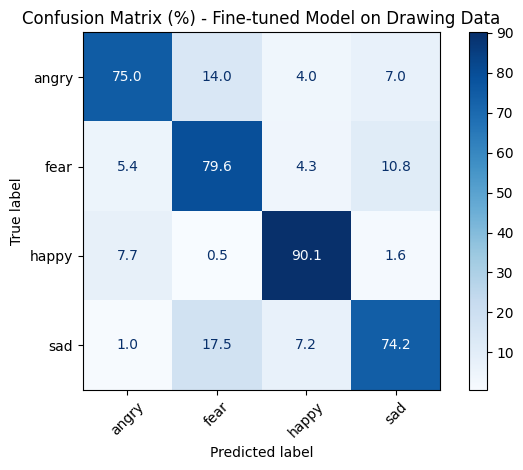


📊 클래스별 정확도:
  angry: 0.7500 (75.00%) - 100개 샘플
  fear: 0.7957 (79.57%) - 93개 샘플
  happy: 0.9011 (90.11%) - 182개 샘플
  sad: 0.7423 (74.23%) - 97개 샘플

🎉 모든 학습 과정이 완료되었습니다!
📁 사전학습 모델: /workspace/models/Inception/inception_pretrained_photo.pth
📁 파인튜닝 모델: /workspace/models/Inception/inception_finetuned_drawing.pth
📁 혼동 행렬: /workspace/models/Inception/confusion_matrix.png


In [10]:
# === Step 3: 최종 평가 및 결과 분석 ===
print("\n" + "="*60)
print("📊 Step 3: 최종 평가 및 결과 분석")
print("="*60)

# 최종 정확도 계산
final_accuracy = accuracy_score(labels, preds)
print(f"🎯 최종 검증 정확도: {final_accuracy:.4f} ({final_accuracy*100:.2f}%)")

# 분류 리포트 출력
print("\n📋 상세 분류 리포트:")
print(classification_report(labels, preds, target_names=drawing_class_names))

# 혼동 행렬 시각화
print("📈 혼동 행렬 생성 중...")
cm = confusion_matrix(labels, preds)

# 💡 백분율로 변환
cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100

plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=drawing_class_names)
disp.plot(cmap='Blues', values_format=".1f")  # 소수점 첫째 자리까지 표현
plt.title('Confusion Matrix (%) - Fine-tuned Model on Drawing Data')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('/workspace/models/Inception/confusion_matrix_percent.png', dpi=300, bbox_inches='tight')
plt.show()


# 클래스별 정확도 분석
print("\n📊 클래스별 정확도:")
for i, class_name in enumerate(drawing_class_names):
    class_mask = [True if label == i else False for label in labels]
    class_preds = [preds[j] for j, mask in enumerate(class_mask) if mask]
    class_labels = [labels[j] for j, mask in enumerate(class_mask) if mask]
    
    if len(class_labels) > 0:
        class_acc = accuracy_score(class_labels, class_preds)
        print(f"  {class_name}: {class_acc:.4f} ({class_acc*100:.2f}%) - {len(class_labels)}개 샘플")

print("\n🎉 모든 학습 과정이 완료되었습니다!")
print(f"📁 사전학습 모델: {photo_model_path}")
print(f"📁 파인튜닝 모델: {drawing_model_path}")
print(f"📁 혼동 행렬: /workspace/models/Inception/confusion_matrix.png")